In [8]:
#Importing necessary libraries
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

from pycaret.regression import *

import random
from deap import base, creator, tools

In [2]:
#Encoding method 1
df = pd.read_excel(r'xrd_new.xlsx', sheet_name='Sheet6')
df = df.drop(['Isc','schw 1', 'schw 2','schw 3', 'schw 4', 'schw 5', 'schw 6'], axis=1)

<AxesSubplot: >

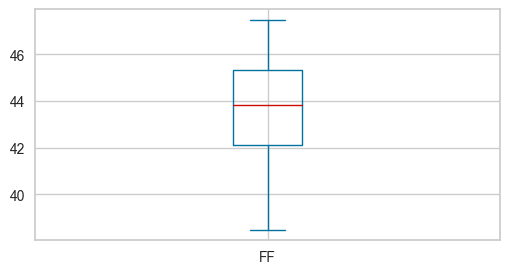

In [3]:
df["FF"].plot(kind="box", figsize=(6,3))

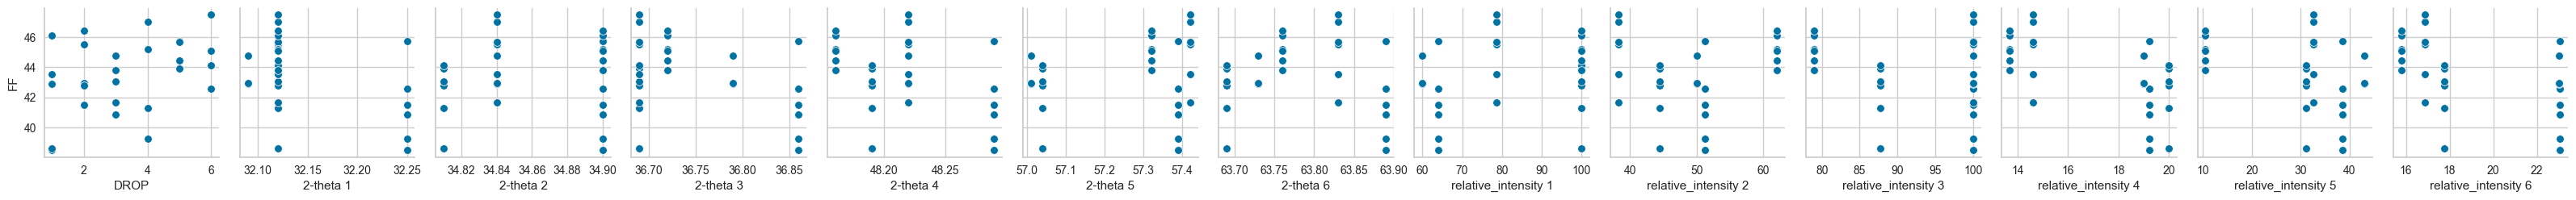

In [4]:
# ''
sns.pairplot(data=df,
                  y_vars=["FF"],
                  x_vars=["DROP", '2-theta 1', '2-theta 2', '2-theta 3', '2-theta 4',
            '2-theta 5', '2-theta 6','relative_intensity 1',
            'relative_intensity 2', 'relative_intensity 3', 'relative_intensity 4',
            'relative_intensity 5', 'relative_intensity 6'])

In [5]:
reg = setup(data=df , target = 'FF' ,normalize=True , normalize_method='minmax',train_size=0.8,fold=3
            ,keep_features=['FWHM 1', 'FWHM 2', 'FWHM 3', 'FWHM 4', 'FWHM 5',
            'FWHM 6', '2-theta 1', '2-theta 2', '2-theta 3', '2-theta 4',
            '2-theta 5', '2-theta 6','relative_intensity 1',
            'relative_intensity 2', 'relative_intensity 3', 'relative_intensity 4',
            'relative_intensity 5', 'relative_intensity 6']
            ,remove_multicollinearity = True, multicollinearity_threshold= 0.9
            , session_id=1543)

,Description,Value
0,Session id,1543
1,Target,FF
2,Target type,Regression
3,Original data shape,"(27, 26)"
4,Transformed data shape,"(27, 26)"
5,Transformed train set shape,"(21, 26)"
6,Transformed test set shape,"(6, 26)"
7,Numeric features,25
8,Keep features,18
9,Preprocess,True


In [6]:
# import RandomForestRegressor from sklearn
best = compare_models(cross_validation=False)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,21:59:38
Status,. . . . . . . . . . . . . . . . . .,Selecting Estimator
Estimator,. . . . . . . . . . . . . . . . . .,Linear Regression


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.4405,0.3105,0.5573,0.9556,0.0120,0.0099,0.0500
dt,Decision Tree Regressor,0.6857,0.9939,0.9969,0.8580,0.0232,0.0159,0.0500
xgboost,Extreme Gradient Boosting,0.7718,1.0272,1.0135,0.8532,0.0223,0.0175,0.1800
ada,AdaBoost Regressor,0.9582,1.1494,1.0721,0.8357,0.0242,0.0224,0.1000
rf,Random Forest Regressor,0.8802,1.1775,1.0851,0.8317,0.0257,0.0212,0.2100
et,Extra Trees Regressor,1.2853,1.7930,1.3390,0.7437,0.0307,0.0302,0.1900
lr,Linear Regression,1.2535,2.2228,1.4909,0.6823,0.0340,0.0293,0.0400
ridge,Ridge Regression,1.1977,2.3783,1.5422,0.6601,0.0359,0.0286,0.0500
huber,Huber Regressor,1.4011,2.7383,1.6548,0.6086,0.0374,0.0326,0.0400
par,Passive Aggressive Regressor,1.2048,2.8422,1.6859,0.5938,0.0397,0.0295,0.0200


In [9]:
# the coefficient of determination of the prediction.
model = create_model('gbr',cross_validation = False, return_train_score=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Test,0.4405,0.3105,0.5573,0.9556,0.0120,0.0099
Train,0.1101,0.0207,0.1438,0.9960,0.0033,0.0025


In [33]:
# Create an evaluation function that takes a combination of features and returns the target value
def evaluate(features_combination):
    # Convert the features_combination to an actual set of input features
    # Use your experiment function here to get the target value based on the combination
    inputs = np.array([features_combination])
    target_value = model.predict(inputs)
    target_value = float(target_value[0])

    return target_value

features = df.drop(columns=["FF"]).to_dict('list' )

# Define the type of optimization (maximize or minimize)
creator.create("FitnessMax", base.Fitness, weights=(1.0,))

# Create an individual (a combination of features) with a defined structure
creator.create("Individual", list, fitness=creator.FitnessMax)

# Initialize the genetic algorithm toolbox
toolbox = base.Toolbox()

# Register the features as attributes with their possible values
for feature_name, feature_values in features.items():
    toolbox.register(f'attr_{feature_name}', random.choice, feature_values)

# Define the structure of an individual (combination of features)
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.__getattribute__(f'attr_{feat}') for feat in features))

# Define the population size and the generation size
population_size = 100
generations = 50

# Define the genetic operators: crossover, mutation, selection, and evaluation
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=0, up=len(features) - 1, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

# Initialize the population
population = [toolbox.individual() for _ in range(population_size)]

# Evaluate the entire population
fitnesses = list(map(toolbox.evaluate, population))
for ind, fit in zip(population, fitnesses):
    ind.fitness.values = fit

# Run the genetic algorithm
for gen in range(generations):
    # Select the next generation individuals
    offspring = toolbox.select(population, len(population))

    # Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))

    # Apply crossover and mutation on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < 0.5:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < 0.2:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Replace the current population with the offspring
    population[:] = offspring

# Get the best individual in the population after generations
best_individual = tools.selBest(population, 1)[0]
best_features_combination = [feature for feature in best_individual]

ValueError: Found array with 0 feature(s) (shape=(1, 0)) while a minimum of 1 is required by GradientBoostingRegressor.

In [9]:
def wrapper(X, Y, **kwargs) -> float:
    
    input = np.array([[X, Y]])
    output = model.predict(input, **kwargs)
    output = float(output)

    if (output > -1) & (output < 10):
        return output
    
    else:
        return 10000000

In [10]:
def optimizer_instantiate(df, wrapper, pbounds, n_iter=10, kappa=5, xi=None, random_state=None):

    # df.plot(kind='scatter', x='X', y='Y', c='Z', cmap='plasma', figsize=(6,5))
    optimizer  = BayesianOptimization(wrapper, pbounds, verbose=2)

    # bo.maximize(init_points=2, n_iter=n_iter, acq='ucb', kappa=kappa)
    # plt.plot(bo.max["params"]["X"],bo.max["params"]["Y"], '*', markersize=10)
    # plt.show()
    utility = UtilityFunction(kind="ucb", kappa=kappa, xi=0)

    return optimizer, utility


def optimizer_suggest(optimizer, utility):
 
    next_point_to_probe = optimizer.suggest(utility)
    print(f"Next Point to Probe: {next_point_to_probe}")
    return next_point_to_probe

In [11]:
features = df.drop(columns=["FF"]).columns.to_list()
pbounds = {feature: (df[feature].min(), df[feature].max()) for feature in features}

# print(f"pbounds: {pbounds}")
# pbounds = {'X': (-5.0, 4.0), 'Y': (-3.0, 7.0)}
optimizer, utility = optimizer_instantiate(df, wrapper, pbounds, n_iter=100, kappa=10, xi=None, random_state=None)

next_point_to_probe = optimizer_suggest(optimizer, utility)
target = model.predict(pd.DataFrame(next_point_to_probe, index=[0]).values.reshape(1, -1))
print("Found the target value to be:", target)

Next Point to Probe: {'2-theta 1': 32.1196676041659, '2-theta 2': 34.843623925744446, '2-theta 3': 36.70936070953455, '2-theta 4': 48.28589697812516, '2-theta 5': 57.254407943671765, '2-theta 6': 63.694756763491824, 'DROP': 4.2624021923594855, 'FWHM 1': 0.19388497390409196, 'FWHM 2': 0.3004467939189523, 'FWHM 3': 0.32839917148426173, 'FWHM 4': 0.45404653969866154, 'FWHM 5': 0.34131134742004987, 'FWHM 6': 0.9070426228676696, 'Intensity 1': 0.7935656457384208, 'Intensity 2': 0.4163271318327498, 'Intensity 3': 0.9372171869928613, 'Intensity 4': 0.1845208008453546, 'Intensity 5': 0.1503597750148207, 'Intensity 6': 0.22008824401330762, 'relative_intensity 1': 84.70886331535118, 'relative_intensity 2': 49.15582190376359, 'relative_intensity 3': 80.80430871703079, 'relative_intensity 4': 18.657635248270395, 'relative_intensity 5': 19.641357205800176, 'relative_intensity 6': 20.92106543944147}
Found the target value to be: [43.49836066]


In [12]:
def bo_run(df, pbounds, n_search_iteration = 20, n_iter=100, kappa=10, xi=None):
    
    optimizer, utility = optimizer_instantiate(df, wrapper, pbounds, n_iter=n_iter, kappa=kappa, xi=None, random_state=None)
    
    for _ in range(n_search_iteration):
        next_point = optimizer.suggest(utility)
        target = model.predict(pd.DataFrame(next_point, index=[0]).values.reshape(1, -1))
        optimizer.register(params=next_point, target=target[0])
        
        print(target, next_point)
        print()
    print(optimizer.max)

### Exploitation (kappa=0.1)

In [13]:
features = df.drop(columns=["FF"]).columns.to_list()
pbounds = {feature: (df[feature].min(), df[feature].max()) for feature in features}

bo_run(df, pbounds, n_search_iteration= 20, n_iter=1000, kappa=0.1, xi=None)

[43.72292716] {'2-theta 1': 32.207866556678056, '2-theta 2': 34.83800584707308, '2-theta 3': 36.75767743438083, '2-theta 4': 48.283035694218306, '2-theta 5': 57.33642042257768, '2-theta 6': 63.88594430910722, 'DROP': 2.3544856023090617, 'FWHM 1': 0.32941816125503975, 'FWHM 2': 0.31246190872605295, 'FWHM 3': 0.43980684830792227, 'FWHM 4': 0.7181212003965639, 'FWHM 5': 0.4611972194689807, 'FWHM 6': 0.39740570682178705, 'Intensity 1': 0.7149294508435479, 'Intensity 2': 0.3681027238206534, 'Intensity 3': 0.7611872520066529, 'Intensity 4': 0.1866276857894839, 'Intensity 5': 0.2987292442835531, 'Intensity 6': 0.1858512658199714, 'relative_intensity 1': 74.14263531596298, 'relative_intensity 2': 42.59731421450131, 'relative_intensity 3': 85.29646646714382, 'relative_intensity 4': 14.88880104249545, 'relative_intensity 5': 26.568391778658405, 'relative_intensity 6': 18.269505084617258}

[43.72292716] {'2-theta 1': 32.20962135111015, '2-theta 2': 34.83089110251594, '2-theta 3': 36.8426393143669

### Exploration  (kappa=10)

In [15]:
bo_run(df, pbounds, n_search_iteration= 20, n_iter=1000, kappa=10, xi=None)

[43.52935192] {'2-theta 1': 32.17678970265408, '2-theta 2': 34.89388992282582, '2-theta 3': 36.797430990204006, '2-theta 4': 48.247254228897916, '2-theta 5': 57.17068976481995, '2-theta 6': 63.75191050347801, 'DROP': 3.4311053488051315, 'FWHM 1': 0.3970923222512027, 'FWHM 2': 0.28247203660478387, 'FWHM 3': 0.24255280202110607, 'FWHM 4': 0.2554507061167378, 'FWHM 5': 0.6326453893100592, 'FWHM 6': 0.8347820867747141, 'Intensity 1': 0.5031261771736175, 'Intensity 2': 0.542258150106322, 'Intensity 3': 0.9190838590882453, 'Intensity 4': 0.13117812642703153, 'Intensity 5': 0.2485052697364149, 'Intensity 6': 0.15295243148275736, 'relative_intensity 1': 76.83689786223465, 'relative_intensity 2': 51.743849408886845, 'relative_intensity 3': 79.46299592940589, 'relative_intensity 4': 19.158423405993435, 'relative_intensity 5': 28.2021803560212, 'relative_intensity 6': 15.933769049191165}

[43.72292716] {'2-theta 1': 32.12796870967425, '2-theta 2': 34.878629521591414, '2-theta 3': 36.6907223962081

### Exploration, Exploitation Tradeoff

In [16]:
bo_run(df, pbounds, n_search_iteration=20, n_iter=1000, kappa=5, xi=None)

[43.50669067] {'2-theta 1': 32.143734771972916, '2-theta 2': 34.84787236251694, '2-theta 3': 36.69888963307708, '2-theta 4': 48.25285438345317, '2-theta 5': 57.13167737804402, '2-theta 6': 63.8588435714579, 'DROP': 4.633409907964918, 'FWHM 1': 0.2879164512640296, 'FWHM 2': 0.2944694789785238, 'FWHM 3': 0.24469765960955692, 'FWHM 4': 0.5672590037117323, 'FWHM 5': 0.5895826721109246, 'FWHM 6': 0.8121565934580999, 'Intensity 1': 0.8733449263481563, 'Intensity 2': 0.5524048122146124, 'Intensity 3': 0.898585608951459, 'Intensity 4': 0.18638994760117272, 'Intensity 5': 0.13154542184094475, 'Intensity 6': 0.1566472496854646, 'relative_intensity 1': 71.23363416694373, 'relative_intensity 2': 58.070055717218395, 'relative_intensity 3': 98.27630889662684, 'relative_intensity 4': 16.52814718497175, 'relative_intensity 5': 19.557600410033427, 'relative_intensity 6': 22.02068087377559}

[43.50669067] {'2-theta 1': 32.24885793303578, '2-theta 2': 34.85423964610775, '2-theta 3': 36.72207274633194, '2

### References
- https://chat.openai.com/share/fddb6a5c-046a-4db1-93f0-e5f6e8fee697
- https://www.kaggle.com/code/marlesson/genetic-algorithm-with-deap
